# Package Processing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import matplotlib.image as image
import pandas as pd

from PIL import Image, ImageFilter
from keras.layers import BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D,Flatten
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-05-28 13:52:34.554825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 13:52:34.554929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 13:52:34.663949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [2]:
csv_path = "/kaggle/input/nptu-dl-final-project/train.csv"
train_path = "/kaggle/input/nptu-dl-final-project/train"

# csv_path = "./nptu-dl-final-project/train.csv"
# train_path = "./nptu-dl-final-project/train"


df = pd.read_csv(csv_path)

y_train = df[['label']]
print(f"All of the img class {len(np.unique(y_train))}")
df

All of the img class 109


,img_file,label
0,78fbc980fba54a0e98da22352d44e51d.jpg,croquet
1,6c761e579cc542ebbaa9a932c9b22b08.jpg,fencing
2,f475146a31564c929e09f0724af3723b.jpg,sailboat racing
3,bfa1d3e9b6684d43ab81eb836670d942.jpg,gymnastics
4,c42ce1c6a0944b0c86a48950f87bc2fe.jpg,roller derby
...,...,...
15193,54e94178e6384782912b465b48979684.jpg,swimming
15194,bb498eaf088349bb8dd9c3d9431ab702.jpg,cheerleading
15195,4640dabdd97a47b1b26ef6bca583927d.jpg,badminton
15196,2593320dd98d400fbc9e0bab4ca98fc1.jpg,luge


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15198 entries, 0 to 15197
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  15198 non-null  object
 1   label     15198 non-null  object
dtypes: object(2)
memory usage: 237.6+ KB


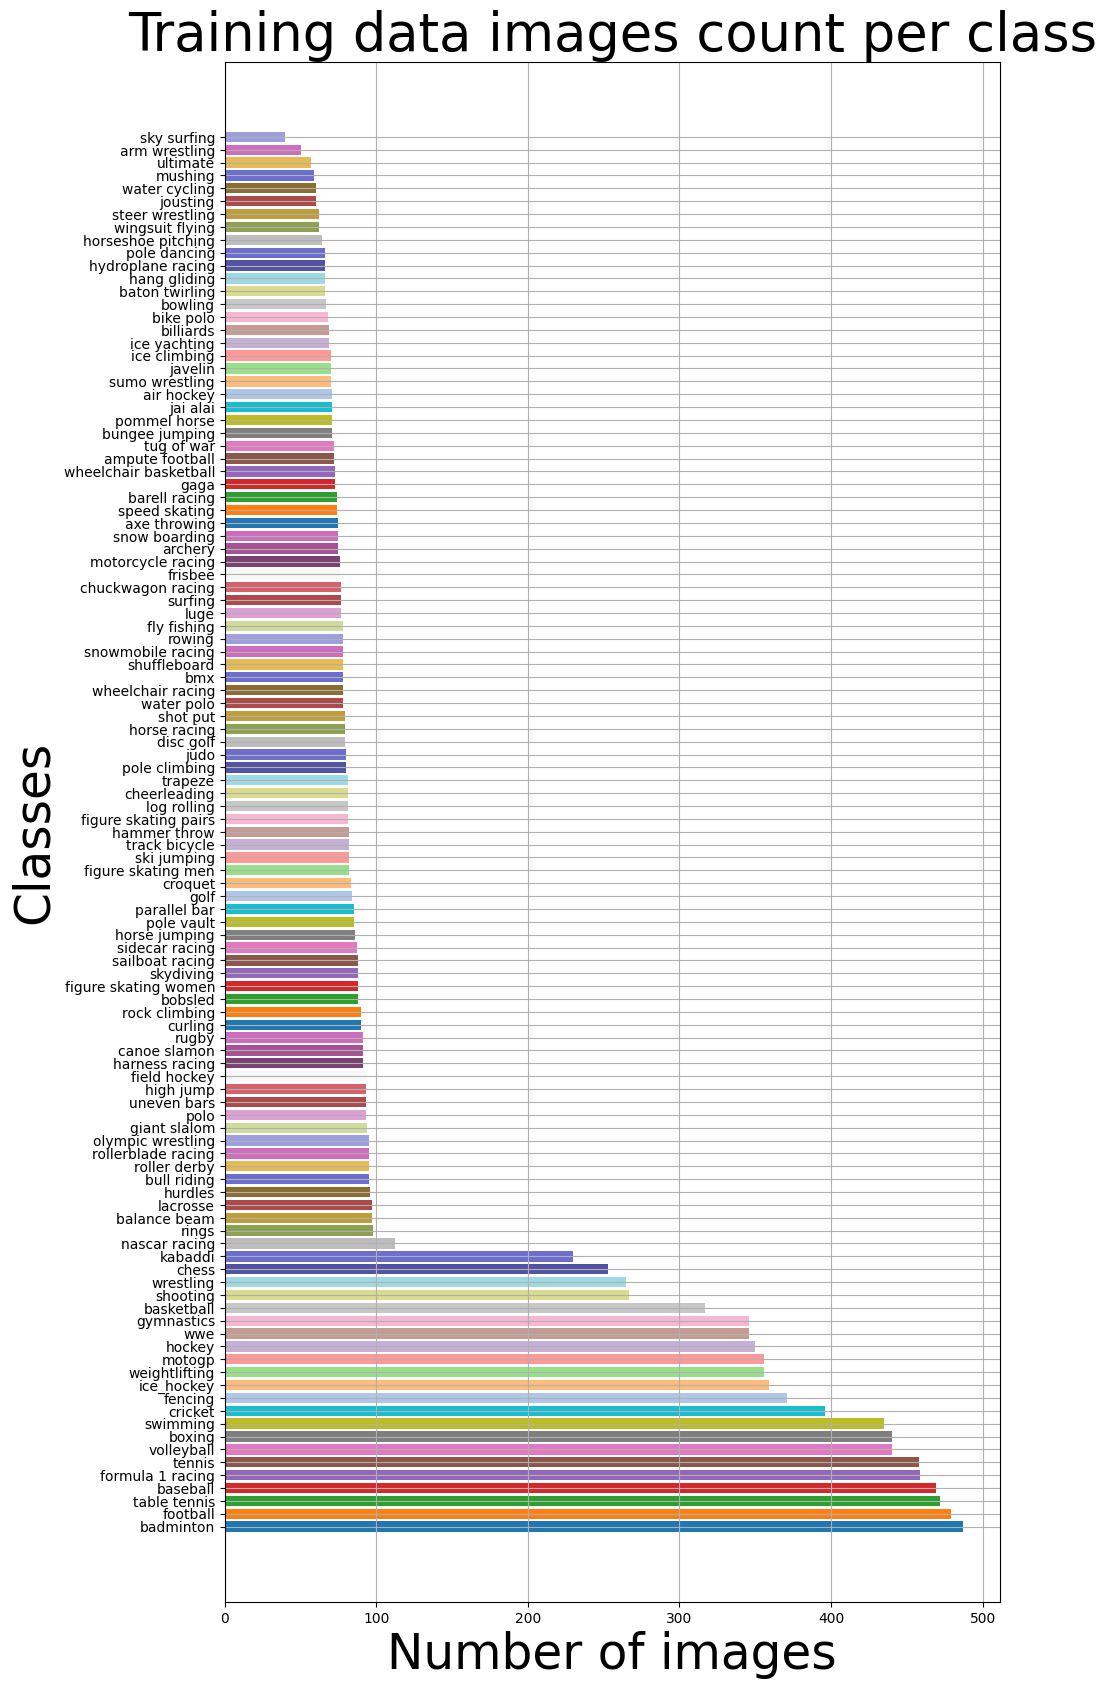

In [4]:
train  = df["label"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(10, 20))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

# Image Processing ( including global parameter )

In [5]:
img_height = 224
img_width = 224
INPUT_SHAPE = (img_height, img_width, 3)

BSIZE = 64
L2 = 0.0001

EPOCHS = 10
LR = 0.001

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split= 0.2
#     channel_shift_range=50, # 隨機修正圖片的顏色
#     vertical_flip=0.5,
#     brightness_range=[0.2,1.0],
    )


train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size= (img_height, img_width),
    batch_size=BSIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)
class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()} 

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='img_file',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BSIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 12159 validated image filenames belonging to 109 classes.
Found 3039 validated image filenames belonging to 109 classes.


In [7]:
# def resize_images(input_dir, output_dir, target_size):
#     # 確保輸出資料夾存在
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # 遍歷輸入資料夾中的所有文件
#     for filename in os.listdir(input_dir):
#         if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
#             file_path = os.path.join(input_dir, filename)
#             output_path = os.path.join(output_dir, filename)
#             with Image.open(file_path) as img:
#                 # 縮放圖像
#                 img = img.resize(target_size, Image.ANTIALIAS)
#                 # 保存縮放後的圖像到輸出資料夾
#                 img.save(output_path)
# output_directory = '/kaggle/working/train_resized'
# target_size = (img_height, img_width)
# resize_images(train_path, output_directory, target_size)

In [8]:
# image1_path = "./nptu-dl-final-project/train/00073f6b7b18474f9c3dad988137d743.jpg"
# image1 = image.imread(image1_path)
# plt.imshow(image1)
# plt.axis(False)
# plt.show()

# image1.shape

# Model Construct 

### Sequential

In [9]:
# model = models.Sequential()
# model.add(layers.Conv2D(filters = 32,
#                         kernel_size = (2, 2),
#                         input_shape = (img_height, img_width, 3),
#                         padding = 'same',
#                         kernel_regularizer = l2(L2),
#                         ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(layers.MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 64,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                  ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size = 2))

# model.add(Conv2D(filters = 128,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 256,
#                  kernel_size=(2,2),
#                  padding='same',
#                  kernel_regularizer = l2(L2),
#                 ))
# # model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# # model.add(Dropout(0.25 , name = 'dropout_1'))

# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(Dropout(0.5, name = 'dropout_2'))
# model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

# model.summary()

### EfficientNetB1

In [10]:
# base_model =  tf.keras.applications.EfficientNetB1(input_shape = INPUT_SHAPE, # Shape of our images
# include_top = False, # Leave out the last fully connected layer
# weights = 'imagenet')

# for layer in base_model.layers:
#     layer.trainable = False

# model = Sequential()
# model.add(base_model)
# model.add(BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(len(train_generator.class_indices), activation='softmax'))
# model.summary()

### MobileNetV2 

In [11]:
base = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
tf.keras.backend.clear_session()
    
for layer in base.layers:
    layer.trainable =  False

model = Sequential()
model.add(base)
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu', kernel_regularizer=l2(L2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(len(train_generator.class_indices), activation='softmax'))
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### MobileNetV3_large

In [12]:
# model = tf.keras.applications.MobileNetV3Small(weights = 'imagenet', include_top = False, input_shape = INPUT_SHAPE)
# net = layers.GlobalAveragePooling2D()(model.output)
# net = Dropout(0.6)(net)
# net = layers.Dense(len(train_generator.class_indices), activation="softmax")(net)

# model = Model(inputs=model.inputs,outputs=net)
# model.summary()

# Callback

In [13]:
# def get_lr_callback(batch_size=8):
#     lr_start   = 0.000005
#     lr_max     = 0.00000125 * batch_size  #最高提到哪裡
#     lr_min     = 0.000001
#     lr_ramp_ep = 5    #warmup 次數
#     lr_sus_ep  = 0
#     lr_decay   = 0.8

#     # call back 要用的
#     def lrfn(epoch):
#         if epoch < lr_ramp_ep:  #算(lr_max-lr_min)/5
#             lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
#         elif epoch < lr_ramp_ep + lr_sus_ep:
#             lr = lr_max
#         else:  #learing rate decay
#             lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
#         return lr

#     lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)  #verbose=1
#     return lr_callback
# lrs = get_lr_callback()

In [14]:
my_callbacks=[EarlyStopping(monitor = "val_loss",
                            patience = 2,
                            restore_best_weights=True,
                           ),
              ReduceLROnPlateau(monitor='val_loss',      # 監測的指標
                                factor=0.2,              # 當指標沒有提升時，減少學習率的因子。新學習率 = 學習率 * factor
                                patience=2,              # 忍受多少個 epochs 的指標沒有提升
                                mode='min'
                         )]

# my_callbacks  = [EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=5,
#                               mode='auto')]


# Training

In [15]:
opt = Adam(learning_rate = LR)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS, 
#                   steps_per_epoch=train_generator.samples // train_generator.batch_size,
#                   validation_steps=validation_generator.samples // validation_generator.batch_size,
                    callbacks=my_callbacks,
                    verbose = 1)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/190 ━━━━━━━━━━━━━━━━━━━━ 1:29:27 28s/step - accuracy: 0.0156 - loss: 5.3500

I0000 00:00:1716904463.060090     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


190/190 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.2337 - loss: 3.6821 - val_accuracy: 0.5314 - val_loss: 1.9101 - learning_rate: 0.0010
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.5500 - loss: 1.7986 - val_accuracy: 0.5841 - val_loss: 1.6443 - learning_rate: 0.0010
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6235 - loss: 1.4600 - val_accuracy: 0.6236 - val_loss: 1.4427 - learning_rate: 0.0010
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.6600 - loss: 1.3166 - val_accuracy: 0.6311 - val_loss: 1.4591 - learning_rate: 0.0010
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.6716 - loss: 1.2206 - val_accuracy: 0.6219 - val_loss: 1.4335 - learning_rate: 0.0010
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.6870 - loss: 1.1820 - val_accuracy: 0.6426 - val_loss: 1.3878 - learning_rate: 0.0010
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7056 - loss: 1.1039 - val_

# Evaluate

In [16]:
scores  = model.evaluate(validation_generator)
scores

48/48 ━━━━━━━━━━━━━━━━━━━━ 46s 964ms/step - accuracy: 0.6684 - loss: 1.3281


[1.3376833200454712, 0.6590983867645264]

In [24]:
print(f"Root mean squared error: {scores[0]:.4f}")
print(f"Test accuracy: {scores[1]:.2%}")

Root mean squared error: 1.3377
Test accuracy: 65.91%


# Visualization

In [18]:
def visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies):
    """
    Function to plot the losses and accuracies
    """
    
    fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title("Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title("Accuracy")
    axes[1].grid()

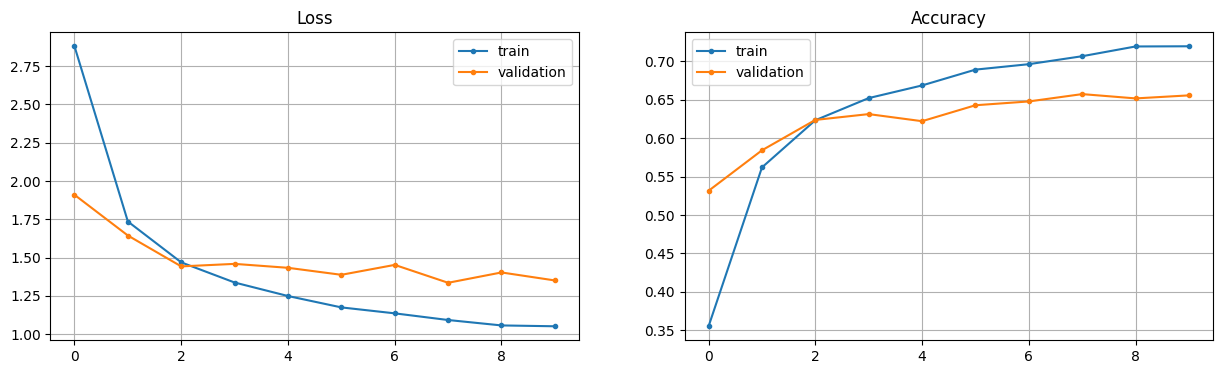

In [19]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
visualize_results(train_loss, train_acc, val_loss, val_acc)

In [20]:
# image2_path = "/kaggle/input/nptu-dl-final-project/test/0017b4ce9b9f48309a6986aea4a1aaa7.jpg"
# image2 = image.imread(image2_path)
# plt.imshow(image2)
# plt.axis(False)
# plt.show()

# image2.shape

# Result

In [21]:
test_path = "/kaggle/input/nptu-dl-final-project/test"
test_datagen = ImageDataGenerator(rescale=1./255)

# 獲取所有圖像文件名稱
test_filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

# 創建 DataFrame
df_test = pd.DataFrame({
    'img_file': test_filenames,
    'label': ['unknown'] * len(test_filenames)  # 這裡的label隨意填寫，因為我們不會用到
})

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='img_file',
    y_col=None,  # 沒有標籤
    target_size=(img_height, img_width),
    batch_size=BSIZE,
    class_mode=None,  # 沒有標籤
    shuffle=False  # 保持文件順序
)

# 預測
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 獲取文件名
filenames = test_generator.filenames
filenames = [f.split('/')[-1] for f in filenames]  # 只保留文件名

Found 12436 validated image filenames.
195/195 ━━━━━━━━━━━━━━━━━━━━ 135s 679ms/step


In [25]:
predicted_labels = [class_indices[int(k)] for k in predicted_classes]
results = pd.DataFrame({
    'img_file': test_filenames,
    'label': predicted_labels
})

# 保存到 .csv 文件
results.to_csv('/kaggle/working/results_2.csv', index=False)
# results.to_csv('/content/results.csv', index=False)